In [1]:
from __future__ import print_function

import os
import re
import cPickle, gzip
import progressbar
from rdkit.Chem import AllChem

data_directory = 'data'
data_filename = '2001-2013_USPTOapplications_reactionSmiles_feb2014filters.rsmi'
removed_mapping_filename = '2001-2013_rsmi_filtered_removed_mapping.pkl.gz'
length_data_filename = 'length_data.pkl.gz'
processed_data_filename = 'processed_data.pkl.gz'

data_filepath = os.path.join(data_directory, data_filename)
removed_mapping_filepath = os.path.join(data_directory, removed_mapping_filename)
length_data_filepath = length_data_filename

processed_data_filepath = os.path.join(data_directory, processed_data_filename)

Remove reaction atom mapping in reaction SMILES string

In [2]:
length_list = [] # list of tuple (reactants length, products length)
num_lines = sum(1 for line in open(data_filepath, 'r')) # total lines
bar = progressbar.ProgressBar(max_value=num_lines)

with open(data_filepath, 'r') as data_file:
    with gzip.open(removed_mapping_filepath, 'wb') as output_file:
        for i, line in enumerate(data_file):
            rsmi = re.split(re.compile(r'[ \t]'), line)
            rxn = AllChem.ReactionFromSmarts(rsmi[0], useSmiles=True)
            AllChem.RemoveMappingNumbersFromReactions(rxn)
            output_smiles = AllChem.ReactionToSmiles(rxn)
            length_list.append((output_smiles.rfind('>'), \
                                len(output_smiles)-output_smiles.rfind('>')-1))
            cPickle.dump((output_smiles, rsmi[2]+rsmi[1]), output_file, 2)
            bar.update(i)

# save length tuple list for later use
with open(length_data_filename, 'wb') as f:
    cPickle.dump(length_list, f, 2)

 99% (1196164 of 1196165) |################ | Elapsed Time: 0:08:33 ETA: 0:00:00

Plot products length by reactants length

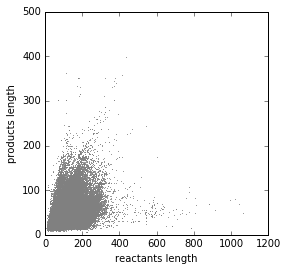

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

with open(length_data_filename, 'rb') as f:
    length_data = cPickle.load(f)

plt.figure(figsize=(4,4))
plt.scatter(*zip(*length_data), s=1, facecolor='0.5', lw=0)
plt.xlabel('reactants length')
plt.ylabel('products length')
plt.xlim(0, 1200)
plt.ylim(0, 500)
plt.show()

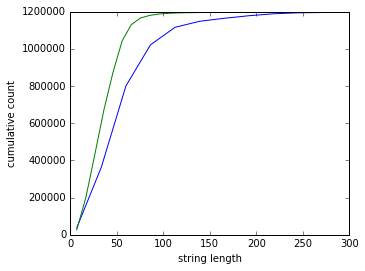

In [4]:
import numpy as np

values, base = np.histogram(zip(*length_data)[0], bins=40)
cumulative = np.cumsum(values)
plt.figure(figsize=(5,4))
plt.plot(base[:-1], cumulative, c='blue') # reactants_length is blue
values, base = np.histogram(zip(*length_data)[1], bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='green') # products_length is green

plt.xlim(0, 300)
plt.xlabel('string length')
plt.ylabel('cumulative count')
plt.show()

length distribution

In [5]:
print("total:", len(length_data))
count = [0, 0, 0, 0]
long_reactants = long_products = 0
list_long_reactants = [] # no list_long_products because long_products was 0
for i, length_tuple in enumerate(length_data):
    if(length_tuple[0] < 150 and length_tuple[1] < 80):
        count[3] += 1
        if(length_tuple[0] < 90 and length_tuple[1] < 65):
            count[2] += 1
            if(length_tuple[0] < 70 and length_tuple[1] < 60):
                count[1] += 1
                if(length_tuple[0] < 54 and length_tuple[1] < 54):
                    count[0] += 1
        if(length_tuple[0] > (10 * length_tuple[1])):
            long_reactants += 1
            list_long_reactants.append(i)
        if((length_tuple[0] * 10) < length_tuple[1]):
            long_products += 1
print("count:", count)
print("long reactants:", long_reactants)
print("long products:", long_products)

total: 1196165
count: [259101, 523004, 791098, 1095631]
long reactants: 37
long products: 0


RSMIs that length_reactants is >10x longer than length_products

In [6]:
with gzip.open(removed_mapping_filepath, 'rb') as data_file:
    i = 1
    while 1:
        try:
            line, _ = cPickle.load(data_file)
            if i in list_long_reactants:
                print("%7d | %s" %(i, line))
        except EOFError:
            break
        i += 1

   9431 | CC(C)CC(N)C(=O)O.CC(C)C[C@H](N)C(=O)O.Cl.O=C(O)CC(O)(CC(=O)O)C(=O)O.O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].[Cl-].[Cl-].[Na+].[Na+].[Na+].[Na+].[OH-].[Zn+2]>O>O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].[Zn]
  18690 | CCOC(=O)CBr.NC1CCCc2ccccc21.NCCc1ccccc1.O=C(O)CN1CCC(N2C(=O)Nc3ccccc32)CC1.O=C1Nc2ccccc2N1C1CCNCC1>CC#N>CCOC(=O)CN1CCC(N2C(=O)Nc3ccccc32)CC1
  22154 | C=CCOC(=O)Cl.CC(C)(C)OC(=O)C(N)CCCCN>CCN(C(C)C)C(C)C.ClCCl>C=CCOC(=O)C(N)CCCCN
  41014 | Cc1ccc(S(=O)(=O)Cl)cc1.Cc1ccc2c(c1)C=CC(C)(C)[NH+]2[O-]>CC(Cl)Cl>Cc1ccc2nc(CCl)ccc2c1
  45021 | CCCCCCCCCCCCN(C)C.O=C=NCCCl>CN(C)C=O>CCCCCCCCCCCC[NH+](C)C.CCNC(N)=O
  78680 | CCCCCCCCCCCCOS(=O)(=O)[O-].Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1.[Na+]>>CCCCCCCCCCCC
  95717 | CCN(CC)CC.COC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)OC(C)(C)C.CS(=O)(=O)Cl>Cc1ccccc1>COC(=O)[C@H](Cc1ccc(OS(C)(=O)=O)cc1)NC(=O)OC(C)(C)C
 110961 | CC(=O)N[C@@H](CS)C(=O)O.[Na+].[OH-]>O>CC(=O)N[C@@H](CS)C(=O)[O-].[Na+]
 124914 | COC(=O)c1ccc(I)cc1N.COC(=

RSMIs' product count

In [7]:
product_num_count = {}
with gzip.open(removed_mapping_filepath, 'rb') as data_file:
    i = 1
    while 1:
        try:
            line, _ = cPickle.load(data_file)
            cnt = line.split('>')[2].count('.') + 1
            if cnt in product_num_count:
                product_num_count[cnt] += 1
            else:
                product_num_count[cnt] = 1
        except EOFError:
            break
        i += 1
        
print(product_num_count)

{1: 1124081, 2: 59213, 3: 10680, 4: 1628, 5: 398, 6: 82, 7: 41, 8: 7, 9: 15, 10: 2, 11: 1, 12: 11, 13: 2, 16: 3, 18: 1}


Collect reaction smiles with products_num smaller than 4
(maybe 'smaller than 3' would make better results?)

In [8]:
bar = progressbar.ProgressBar(max_value=len(length_data))

with gzip.open(removed_mapping_filepath, 'rb') as data_file:
    with gzip.open(processed_data_filepath, 'wb') as processed_file:
        i = 1
        while 1:
            try:
                line, ref = cPickle.load(data_file)
                products_num = line.split('>')[2].count('.') + 1                
                reactants_length = line.rfind('>')
                products_length = len(line)-line.rfind('>')-1
                if (reactants_length < 150 and products_length < 80):
                    if (products_num < 4):
                        cPickle.dump((line, ref), processed_file, 2)
            except EOFError:
                break
            bar.update(i)
            i += 1

100% (1196165 of 1196165) |################| Elapsed Time: 0:00:31 ETA:  0:00:00